In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoDimer(specifications.CoiledCoil):
    """Specification for creating anti-parallel, homodimeric coiled coils."""
    
    oligomeric_state = 2
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 2 helices, we have 2 values for each of these, but in this case they
        # are the same as we're making a homodimer
        self.aas = [helix_length, helix_length]
        self.major_radii = [radius, radius]
        self.major_pitches = [pitch, pitch]
        self.z_shifts = [0, zshift]
        self.phi_c_alphas = [phica, phica]
        
        # We need to set the orientation of the helices to be anti-parallel, so one
        # needs to have a +1 orientation and the other needs a -1 orientation
        self.orientations = [1, -1]

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAALKQEIAALKKEAAALKWEIAALKQGYY', 'GEIAALKQEIAALKKEAAALKWEIAALKQGYY']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 5.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['g'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 5.0, 200, 257, 10]


### Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoDimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std   	min     	max     
0  	71   	-872.465	23.592	-927.775	-831.783
1  	68   	-888.729	16.8147	-930.196	-860.431
2  	69   	-903.206	13.3839	-955.451	-880.435
3  	77   	-911.874	13.1335	-955.451	-894.85 
4  	74   	-923.625	12.5645	-960.485	-905.713
5  	61   	-934.35 	12.1179	-966.605	-915.81 
6  	79   	-946.872	7.70053	-966.605	-933.724
7  	82   	-953.496	5.97139	-970.315	-945.136
8  	70   	-959.528	5.41326	-970.315	-951.47 
9  	77   	-964.103	4.68191	-973.603	-956.348
10 	80   	-967.894	2.89058	-973.603	-961.591
11 	87   	-969.627	1.70848	-973.603	-965.824
12 	60   	-970.132	1.43039	-973.603	-967.155
13 	67   	-970.993	1.11629	-973.603	-969.168
14 	70   	-971.655	1.08901	-974.717	-970.03 
15 	70   	-972.325	0.95526	-974.717	-970.662
16 	67   	-972.946	0.797112	-975.432	-971.619
17 	57   	-973.241	0.973443	-975.629	-971.701
18 	76   	-974.123	0.734905	-975.764	-972.859
19 	59   	-974.692	0.61716 	-975.764	-973.549
20 	62   	-975.011	0.510998	-975.86 	-973.951
21 	74 

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-976.0735433816884

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

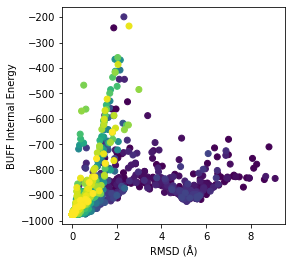

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('d_CC-Di-A17_ap-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-860.701	41.8393	-959.689	-625.449
1  	100  	-876.046	23.9574	-959.689	-832.523
2  	100  	-886.337	24.2514	-959.689	-832.523
3  	100  	-895.305	24.4562	-959.689	-833.943
4  	100  	-903.295	22.6667	-959.689	-860.096
5  	100  	-912.748	21.7412	-974.511	-874.255
6  	100  	-922.913	22.4682	-974.511	-876.621
7  	100  	-932.353	21.0347	-974.511	-886.157
8  	100  	-943.055	19.3734	-974.511	-898.482
9  	100  	-951.595	15.9777	-974.511	-908.392
10 	100  	-956.808	14.4572	-980.412	-908.392
11 	100  	-964.417	9.21904	-980.412	-918.274
12 	100  	-967.856	6.45065	-980.412	-939.59 
13 	100  	-970.259	5.62652	-980.412	-950.742
14 	100  	-972.425	4.37882	-982.077	-958.532
15 	100  	-974.555	3.46166	-982.077	-966.787
16 	100  	-975.885	3.19015	-982.077	-968.071
17 	100  	-977.146	2.92335	-982.798	-969.367
18 	100  	-978.314	2.70295	-983.484	-972.208
19 	100  	-980.026	2.10122	-983.498	-974.222
20 	100  	-980.939	1.76073	-984.063	-975.272
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-986.2317706864072

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

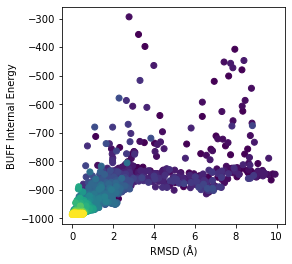

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('d_CC-Di-A17_ap-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg    	std    	min     	max   
0  	100  	-805.32	116.666	-935.621	-284.2
1  	89   	-841.09	129.381	-953.688	-320.883
2  	69   	-823.384	141.759	-958.51 	-244.588
3  	70   	-833.381	103.919	-951.159	-244.588
4  	79   	-825.873	130.563	-970.829	-154.327
5  	68   	-813.294	163.611	-995.91 	-154.327
6  	44   	-818.823	144.163	-995.91 	-154.327
7  	67   	-825.079	131.952	-957.165	-154.327
8  	77   	-834.069	109.877	-965.692	-351.37 
9  	85   	-822.875	125.915	-965.692	-135.672
10 	86   	-830.088	104.407	-965.692	-135.672
11 	87   	-836.485	118.891	-949.968	-135.672
12 	81   	-823.709	162.947	-953.049	-12.9183
13 	69   	-797.928	160.012	-969.39 	-12.9183
14 	70   	-844.679	98.0293	-964.516	-433.976
15 	85   	-864.371	29.7776	-947.418	-748.459
16 	80   	-858.258	44.8525	-931.832	-622.441
17 	83   	-796.206	176.591	-987.752	-118.057
18 	55   	-767.6  	184.968	-987.752	-118.057
19 	66   	-808.448	168.23 	-987.752	-118.057
20 	82   	-839.837	102.991	-964.919	-347.858
21 	90   	-848.30

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-995.9101991133354

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

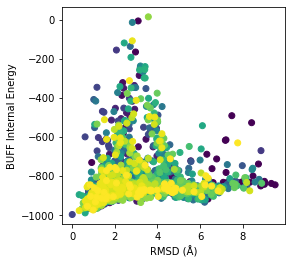

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('d_CC-Di-A17_ap-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoDimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-853.888	31.9572	-917.294	-641.905
1  	100  	-830.231	69.0044	-927.716	-538.181
2  	100  	-854.312	51.339 	-931.022	-535.754
3  	100  	-854.026	54.8106	-953.095	-512.227
4  	100  	-839.899	94.7397	-960.353	-355.94 
5  	100  	-848.637	109.389	-949.693	-253.304
6  	100  	-890.294	58.6862	-970.886	-657.333
7  	100  	-896.351	75.2124	-957.577	-503.203
8  	100  	-926.141	21.5066	-962.491	-815.48 
9  	100  	-929.864	18.8518	-964.431	-860.54 
10 	100  	-935.1  	17.0513	-961.678	-893.039
11 	100  	-938.696	16.9567	-964.82 	-896.058
12 	100  	-940.577	17.0562	-964.982	-896.699
13 	100  	-942.494	17.1976	-963.812	-899.483
14 	100  	-949.129	12.9597	-964.421	-900.627
15 	100  	-950.991	14.3325	-965.091	-896.41 
16 	100  	-952.278	15.2415	-965.944	-914.12 
17 	100  	-949.632	17.5007	-966.463	-912.852
18 	100  	-955.541	14.8305	-966.534	-915.189
19 	100  	-960.54 	9.41923	-966.555	-920.529
20 	100  	-961.996	6.37047	-966.702	-922.195
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-970.8858255689139

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

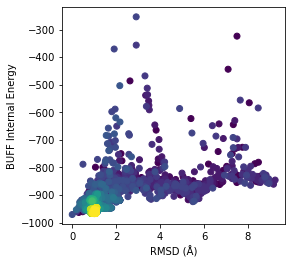

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('d_CC-Di-A17_ap-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)